In [10]:
import cv2
import os

os.makedirs("frames", exist_ok=True)
os.makedirs("vis_result", exist_ok=True)
os.makedirs("field_data", exist_ok=True)

vidcap = cv2.VideoCapture('laminar_jet_with_tracer_particles_for_piv.mp4')
success,image = vidcap.read()
count = 0
while success:
    cv2.imwrite("frames/frame%04d.jpg" % count, image)          # save frame as JPEG file      
    success,image = vidcap.read()
    count += 1
print(count)

In [8]:
import numpy as np
from matplotlib import collections as mc
from matplotlib import pyplot as plt

def match_two_frame(args):

    im0, im1, save_fig_fn, show = args

    sift = cv2.SIFT_create()

    kp0, des0 = sift.detectAndCompute(im0, None)   # queryImage
    kp1, des1 = sift.detectAndCompute(im1, None)   # trainImage

    print("len(kp0)", len(kp0))
    print("len(kp1)", len(kp1))

    # img = cv2.drawKeypoints(im0, kp, im0)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des0,des1, k=2)

    good = []
    
#     matches = sorted(matches, key=lambda x: x[0].distance / x[1].distance)
    
    for m,n in matches:
        qi = m.queryIdx
        ti = m.trainIdx

        qx = [ kp0[qi].pt[0], kp0[qi].pt[1] ]
        tx = [ kp1[ti].pt[0], kp1[ti].pt[1] ]

        _n = np.linalg.norm(np.array(qx) - np.array(tx))

#         if m.distance < 0.8*n.distance and _n < 30:
#         if m.distance < 0.8*n.distance and _n < 20:
#         if m.distance < n.distance and _n < 20:
        if m.distance < 0.7*n.distance and _n < 20:
            good.append([m])

    img = cv2.drawMatchesKnn(im0,kp0,im1,kp1,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    plt.imshow(img)
    plt.show()

    qxs = []
    txs = []

    for mm in good:
        m = mm[0]

        qi = m.queryIdx
        ti = m.trainIdx

        qx = [ kp0[qi].pt[0], kp0[qi].pt[1] ]
        tx = [ kp1[ti].pt[0], kp1[ti].pt[1] ]

        qxs.append(qx)
        txs.append(tx)

    qxs = np.array(qxs)
    txs = np.array(txs)


    ns = np.linalg.norm(qxs - txs, axis=1)


    lines = np.concatenate((qxs[:, np.newaxis, :], txs[:, np.newaxis, :]), axis=1)
    
    if save_fig_fn:
        np.save("field_data/" + save_fig_fn, lines)    


    lines = [[ (l[0][0], l[0][1]), (l[1][0], l[1][1]) ] for l in lines]

    # c = np.array([[0,0,0,1]]).repeat(len(lines), axis=0)

    c = np.sign(ns-10) * np.power(ns-10, 2.0) / 10 + 10
#     c = np.power(ns-10, 3.0) / 100 + 10

    print("Index: ", save_fig_fn, "V max:", ns.max(), "Points num:", len(qxs))


    # lines = [[(0, 1), (1, 1)], [(2, 3), (3, 3)], [(1, 2), (1, 3)]]
    # c = np.array([(1, 0, 0, 1), (0, 1, 0, 1), (0, 0, 1, 1)])

    linewidths = 1 + c / 30
    
    lc = mc.LineCollection(lines, array=c, cmap=plt.cm.jet, norm=plt.Normalize(vmin=0, vmax=20), linewidths=linewidths)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8), dpi=150)

    ax1.add_collection(lc)

    ax1.autoscale()
    ax1.margins(0.1)

    ax1.set_aspect(1)

    ax1.set_xlim(0, 512)
    ax1.set_ylim(0, 720)

    ax1.invert_yaxis()

    # ax2.imshow(cv2.GaussianBlur(im1, (11,11),cv2.BORDER_DEFAULT)-cv2.GaussianBlur(im0, (11,11),cv2.BORDER_DEFAULT))

    ax2.imshow(im1, cmap='gray')

    if save_fig_fn:
        import os
        plt.savefig("vis_result/"+save_fig_fn+".jpg", bbox_inches='tight')

    if show:
        plt.show()
        
    plt.close("all")

    return save_fig_fn

len(kp0) 7306
len(kp1) 7841


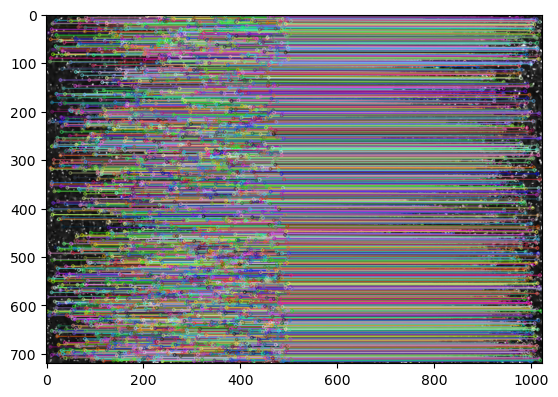

Index:  None V max: 18.854602051034153 Points num: 3892


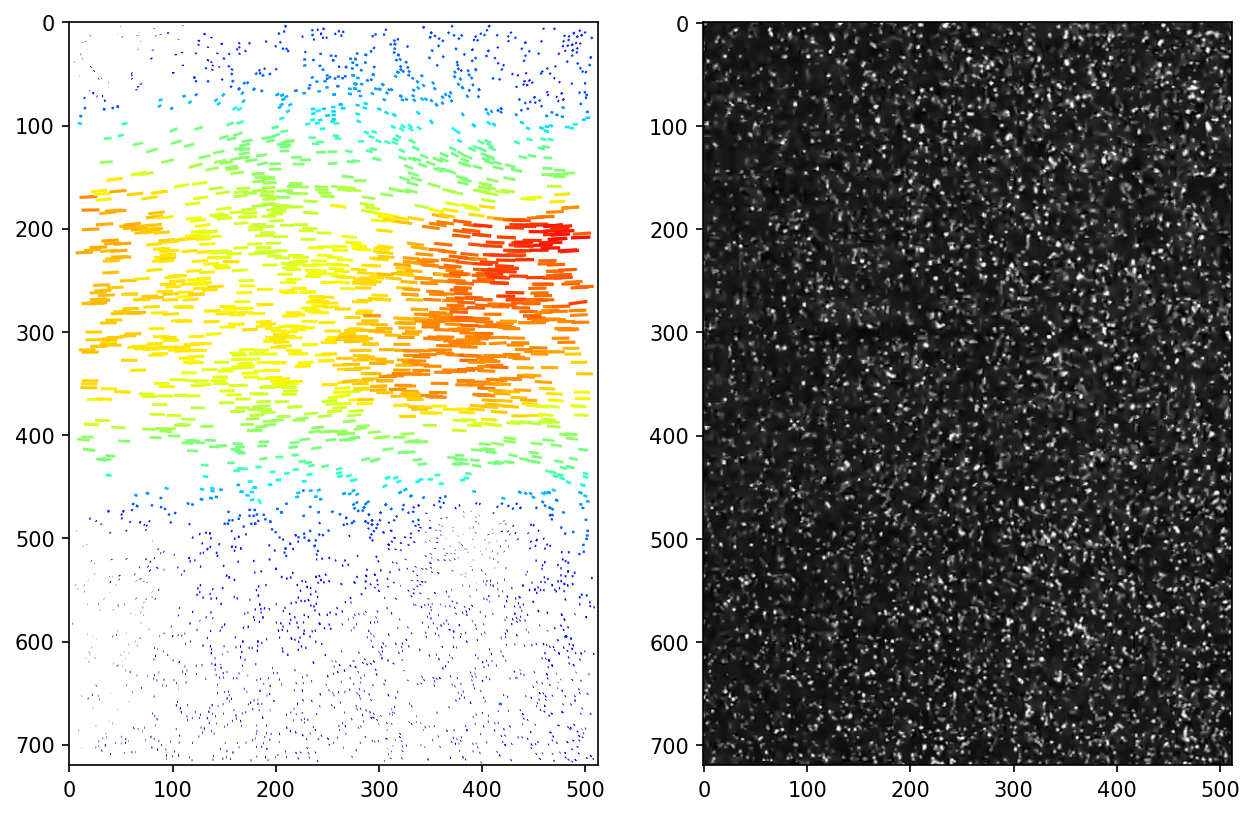

In [10]:
im0 = cv2.imread('./frames/frame0000.jpg', cv2.IMREAD_GRAYSCALE)
im1 = cv2.imread('./frames/frame0001.jpg', cv2.IMREAD_GRAYSCALE)

# match_two_frame((im0, im1, "0000", True))
match_two_frame((im0, im1, None, True))

In [93]:
import os

dir_ = "./frames/"

frames_fn = sorted([os.path.join(dir_, fn) for fn in os.listdir(dir_)])

FRAMES = [cv2.imread(fn, cv2.IMREAD_GRAYSCALE) for fn in frames_fn]

args = [(FRAMES[ii], FRAMES[ii+1], "%04d" % ii, False) for ii in range(len(FRAMES)-1)]

print("START")


# import multiprocessing

# def driver_func():
#     PROCESSES = 40
#     with multiprocessing.Pool(PROCESSES) as pool:
#         pool.map(match_two_frame, args)


# driver_func()

for arg in args:
    match_two_frame(arg)

print('END')


START
Index:  0000 V max: 18.854602051034153 Points num: 3892
Index:  0001 V max: 19.4492277929826 Points num: 3452
Index:  0002 V max: 18.968565253816482 Points num: 4041
Index:  0003 V max: 18.822663554817336 Points num: 3223
Index:  0004 V max: 18.822679346114253 Points num: 4418
Index:  0005 V max: 18.688293077914956 Points num: 3309
Index:  0006 V max: 18.937425541068684 Points num: 4477
Index:  0007 V max: 18.819298094918064 Points num: 3493
Index:  0008 V max: 18.768563445463748 Points num: 4809
Index:  0009 V max: 19.086015461569428 Points num: 3725
Index:  0010 V max: 18.901527606640094 Points num: 4674
Index:  0011 V max: 18.23445233367041 Points num: 3576
Index:  0012 V max: 17.98389206231346 Points num: 4497
Index:  0013 V max: 18.617639400273852 Points num: 3414
Index:  0014 V max: 17.764612628124738 Points num: 4840
Index:  0015 V max: 18.04838150422672 Points num: 3298
Index:  0016 V max: 17.76731772180761 Points num: 4602
Index:  0017 V max: 18.00999234736648 Points num

Index:  0148 V max: 19.957961233945824 Points num: 3907
Index:  0149 V max: 19.136316765124665 Points num: 4632
Index:  0150 V max: 19.550545040236617 Points num: 3793
Index:  0151 V max: 19.804684673123138 Points num: 4436
Index:  0152 V max: 19.91978368314753 Points num: 4011
Index:  0153 V max: 19.836513661380653 Points num: 4887
Index:  0154 V max: 19.349375470737336 Points num: 4238
Index:  0155 V max: 19.568368407234374 Points num: 4269
Index:  0156 V max: 19.655911424436546 Points num: 4176
Index:  0157 V max: 19.59820323295027 Points num: 4896
Index:  0158 V max: 19.65509505752336 Points num: 4034
Index:  0159 V max: 19.320155369080688 Points num: 4584
Index:  0160 V max: 19.512146535471153 Points num: 3990
Index:  0161 V max: 19.975379477599315 Points num: 4788
Index:  0162 V max: 19.87692689013036 Points num: 4006
Index:  0163 V max: 19.747062315848922 Points num: 4727
Index:  0164 V max: 19.241564239758215 Points num: 3665
Index:  0165 V max: 19.27155153517611 Points num: 49

Index:  0296 V max: 19.380215302041055 Points num: 4005
Index:  0297 V max: 18.859273498226656 Points num: 4895
Index:  0298 V max: 19.533814236976227 Points num: 4141
Index:  0299 V max: 19.38728424681863 Points num: 4903
Index:  0300 V max: 19.375830217641 Points num: 4046
Index:  0301 V max: 19.375063891777753 Points num: 4629
Index:  0302 V max: 19.179531874530298 Points num: 3699
Index:  0303 V max: 19.018614010706088 Points num: 4825
Index:  0304 V max: 19.075608293541816 Points num: 4001
Index:  0305 V max: 19.112021944924056 Points num: 4901
Index:  0306 V max: 19.001639036479023 Points num: 3991
Index:  0307 V max: 18.97123128856215 Points num: 4903
Index:  0308 V max: 18.96762899865278 Points num: 4176
Index:  0309 V max: 19.44106812450861 Points num: 4305
Index:  0310 V max: 19.06856351640283 Points num: 5011
Index:  0311 V max: 19.24445952369792 Points num: 4181
Index:  0312 V max: 19.055499292696783 Points num: 4879
Index:  0313 V max: 19.06563719868211 Points num: 4259
In

Index:  0444 V max: 17.44142279212996 Points num: 5580
Index:  0445 V max: 17.48174755062675 Points num: 5192
Index:  0446 V max: 17.25841849546468 Points num: 5672
Index:  0447 V max: 17.888690032651972 Points num: 733
Index:  0448 V max: 17.44941141781156 Points num: 4388
Index:  0449 V max: 17.584565441401967 Points num: 4736
Index:  0450 V max: 17.800258815733205 Points num: 3854
Index:  0451 V max: 17.878176994736545 Points num: 4757
Index:  0452 V max: 17.623337600200482 Points num: 4033
Index:  0453 V max: 18.614721419252493 Points num: 4971
Index:  0454 V max: 18.20330049907007 Points num: 4189
Index:  0455 V max: 17.800179736183114 Points num: 5389
Index:  0456 V max: 17.70528111766218 Points num: 4268
Index:  0457 V max: 17.89758981864997 Points num: 5163
Index:  0458 V max: 17.837777390840685 Points num: 4204
Index:  0459 V max: 17.908468191324427 Points num: 5457
Index:  0460 V max: 17.767512163600863 Points num: 4267
Index:  0461 V max: 17.865534922803725 Points num: 5155


Index:  0592 V max: 18.61254380010269 Points num: 4607
Index:  0593 V max: 18.553224450202737 Points num: 5017
Index:  0594 V max: 18.65807701666902 Points num: 4238
Index:  0595 V max: 18.712205115431264 Points num: 5351
Index:  0596 V max: 18.59184464751978 Points num: 4484
Index:  0597 V max: 18.47186202078506 Points num: 5354
Index:  0598 V max: 18.7074238496649 Points num: 4437
Index:  0599 V max: 18.93904285710874 Points num: 4820
Index:  0600 V max: 18.271222934682342 Points num: 4519
Index:  0601 V max: 18.275249339112317 Points num: 5293
Index:  0602 V max: 18.16616281100232 Points num: 4628
Index:  0603 V max: 18.00767488864049 Points num: 5195
Index:  0604 V max: 18.015346786012497 Points num: 4760
Index:  0605 V max: 18.267327753977046 Points num: 5381
Index:  0606 V max: 17.954961792462043 Points num: 4631
Index:  0607 V max: 17.72962749290893 Points num: 5311
Index:  0608 V max: 17.7973944645633 Points num: 4576
Index:  0609 V max: 17.773823721132068 Points num: 5480
Inde

Index:  0740 V max: 17.882052822121235 Points num: 4263
Index:  0741 V max: 17.838470316670104 Points num: 5072
Index:  0742 V max: 18.246091160649502 Points num: 4310
Index:  0743 V max: 18.44456561470265 Points num: 5022
Index:  0744 V max: 18.13697856913747 Points num: 4189
Index:  0745 V max: 18.063217368349015 Points num: 5091
Index:  0746 V max: 18.504584533449396 Points num: 4300
Index:  0747 V max: 17.975955906908265 Points num: 4946
Index:  0748 V max: 18.610366215872503 Points num: 4170
Index:  0749 V max: 18.50821416059925 Points num: 4969
Index:  0750 V max: 19.750605249775294 Points num: 4452
Index:  0751 V max: 18.183722889292913 Points num: 5061
Index:  0752 V max: 18.358155004289657 Points num: 4443
Index:  0753 V max: 18.52202468831029 Points num: 5200
Index:  0754 V max: 18.23237305802822 Points num: 4338
Index:  0755 V max: 19.170673632176914 Points num: 5109
Index:  0756 V max: 18.79077728280242 Points num: 4223
Index:  0757 V max: 18.468579670344322 Points num: 477

Index:  0888 V max: 18.341903533885404 Points num: 5755
Index:  0889 V max: 17.75929190947976 Points num: 4781
Index:  0890 V max: 17.209454983894148 Points num: 5512
Index:  0891 V max: 17.643037490466302 Points num: 4765
Index:  0892 V max: 17.328799578076868 Points num: 5320
Index:  0893 V max: 17.608985908268497 Points num: 4900
Index:  0894 V max: 18.12864537507047 Points num: 5135
Index:  0895 V max: 18.759757102923913 Points num: 722
Index:  0896 V max: 17.57725540563908 Points num: 4245
Index:  0897 V max: 18.1677123663021 Points num: 4497
Index:  0898 V max: 18.187038611311436 Points num: 3975
Index:  0899 V max: 17.247627130451686 Points num: 4802
Index:  0900 V max: 17.459309535819866 Points num: 4072
Index:  0901 V max: 17.5462450182636 Points num: 4861
Index:  0902 V max: 17.68266042449911 Points num: 4039
Index:  0903 V max: 17.56271348392687 Points num: 5091
Index:  0904 V max: 18.047264100377344 Points num: 4043
Index:  0905 V max: 17.433605267074636 Points num: 5195
In

Index:  1036 V max: 19.24492485932099 Points num: 4245
Index:  1037 V max: 18.78656269285012 Points num: 5023
Index:  1038 V max: 18.654885631790435 Points num: 4327
Index:  1039 V max: 19.05278655868811 Points num: 4673
Index:  1040 V max: 19.034573743253432 Points num: 4540
Index:  1041 V max: 18.523373244522865 Points num: 5141
Index:  1042 V max: 18.485294671556545 Points num: 4495
Index:  1043 V max: 18.118897634027007 Points num: 5315
Index:  1044 V max: 18.85051633475854 Points num: 4733
Index:  1045 V max: 18.025668099445554 Points num: 5303
Index:  1046 V max: 17.88503828184035 Points num: 4687
Index:  1047 V max: 18.19755955452888 Points num: 5356
Index:  1048 V max: 18.694487932232253 Points num: 4357
Index:  1049 V max: 18.912875179422976 Points num: 5058
Index:  1050 V max: 17.771060433443573 Points num: 4518
Index:  1051 V max: 17.49881672331284 Points num: 5114
Index:  1052 V max: 17.64985353949766 Points num: 4617
Index:  1053 V max: 17.85357118844686 Points num: 5353
I

Index:  1184 V max: 19.165127719406815 Points num: 4224
Index:  1185 V max: 19.015583116677284 Points num: 5191
Index:  1186 V max: 18.831532869596664 Points num: 4577
Index:  1187 V max: 18.454013262983246 Points num: 5296
Index:  1188 V max: 18.147042822140854 Points num: 4554
Index:  1189 V max: 18.24659140517656 Points num: 4374
Index:  1190 V max: 18.68886028402569 Points num: 5252
Index:  1191 V max: 18.227956782417973 Points num: 4426
Index:  1192 V max: 18.677654135145847 Points num: 4586
Index:  1193 V max: 18.706912615278263 Points num: 4444
Index:  1194 V max: 18.32686962406594 Points num: 5198
Index:  1195 V max: 18.25880234193949 Points num: 4983
Index:  1196 V max: 19.56002154937537 Points num: 4124
Index:  1197 V max: 18.821683652035354 Points num: 4847
END
